In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle


from surprise import KNNWithMeans, KNNBasic, SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, mean_absolute_error
from sklearn import model_selection
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from xgboost import XGBClassifier

c:\Projects\DS\recommendation_system\.venv\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 0. Задания модулей

**Задание 2.1**

Сколько записей событий находится в датасете? Ответ введите без пробелов и знаков препинания.

In [2]:
events = pd.read_csv('data\events.csv.zip')
events.sample(5)

,timestamp,visitorid,event,itemid,transactionid
1252434,1441578086111,708070,view,338411,NaN
1756298,1431919964944,457176,view,11884,NaN
1653515,1431450634446,783023,view,114596,NaN
2092208,1435863713786,712582,view,235992,NaN
249144,1434170817906,1152518,view,61487,NaN


In [3]:
print('В датасете', len(events.index), 'записей')

В датасете 2756101 записей


**Задание 2.2**

Какие типы событий содержатся в датасете? Выберите все верные варианты.

In [4]:
events.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

Типы событий:  

view (просмотр карточки товара)  
addtocart (добавление в корзину)  
transaction (покупка)

**Задание 2.3**

Сколько уникальных признаков товара есть в датасете? Ответ вводите без пробелов и знаков препинания.

In [5]:
item_properties_1 = pd.read_csv('data\item_properties_part1.csv')
item_properties_2 = pd.read_csv('data\item_properties_part2.csv')
item_properties =pd.concat([item_properties_1, item_properties_2], axis=0)
item_properties.sample(5)

,timestamp,itemid,property,value
1354567,1433646000000,378875,915,72261 505888
3536987,1441508400000,34571,506,309080 285933
8008149,1439694000000,293143,961,1326027
7675109,1434250800000,46305,available,1
5459114,1437879600000,229246,888,1009435 36244


In [6]:
print('В датасете', item_properties.property.nunique(), 'признаков товара')

В датасете 1104 признаков товара


events — датасет с событиями. Колонки:

timestamp — время события  
visitorid — идентификатор пользователя  
event — тип события  
itemid — идентификатор объекта  
transactionid — идентификатор транзакции, если она проходила  
category_tree — файл с деревом категорий (можно восстановить дерево).  

category_id — идентификатор категорий  
parent_id — идентификатор родительской категории  
item_properties — файл с свойствами товаров.  

timestamp — момент записи значения свойства  
item_id — идентификатор объекта  
property — свойство, кажется, они все, кроме категории, захешированы  
value — значение свойства  

**Задание 4.1**

Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)? Для расчёта используйте топ-3 товаров по числу транзакций.

Ответ введите без знака процента.

In [7]:
events['datetime']=pd.to_datetime(events.timestamp, unit='ms')
events.datetime.max()

Timestamp('2015-09-18 02:59:47.788000')

In [8]:
top_products = events[(events.datetime<='2015-07-01') & (events.event=='transaction')].itemid.value_counts(normalize=True).iloc[:3].index

In [9]:
persent_3 = events[(events.datetime>='2015-07-01') & (events.event=='transaction')].itemid.value_counts(normalize=True).loc[[top_products[0],top_products[2]]].sum()*100
print('Процент продаж топ трех товаров', persent_3)

Процент продаж топ трех товаров 0.6014215418261345


**Задание 2.1**

Серёга: Твой выход! Какой тип валидации в данном случае нужно использовать?

In [10]:
events.itemid.value_counts(normalize=True)

itemid
187946    1.237981e-03
461686    1.080512e-03
5411      8.468485e-04
370653    6.726894e-04
219512    6.530965e-04
              ...     
357730    3.628314e-07
62768     3.628314e-07
404071    3.628314e-07
145333    3.628314e-07
177353    3.628314e-07
Name: proportion, Length: 235061, dtype: float64

**Задание 0.1**

Только подскажи, пожалуйста, какое свойство айтемов не входит в топ-20?

In [11]:
categories = pd.read_csv("data\category_tree.csv")

In [12]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit = 'ms')
item_properties['event_datetime'] = pd.to_datetime(item_properties['timestamp'], unit = 'ms')

In [13]:
events['day_of_week'] = events['event_datetime'].map(lambda x: x.weekday())
events['Year'] = events['event_datetime'].map(lambda x: x.year)
events['Month'] = events['event_datetime'].map(lambda x: x.month)
events['Day'] = events['event_datetime'].map(lambda x: x.day)
events['Hour'] = events['event_datetime'].map(lambda x: x.hour)
events['minute'] = events['event_datetime'].map(lambda x: x.minute)

In [14]:
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
events['Day Period'] = events['Hour'].map(get_time_periods)
events['Day Period'].value_counts()

Day Period
Evening      1078199
Night         765924
Dawn          494588
Afternoon     293490
Morning       123900
Name: count, dtype: int64

In [15]:
# Возьмем только самые распространенные proprties, например топ 20 (при построении модели можно играть)
top_properties = item_properties.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:10]

In [16]:
properties_filtered = item_properties[item_properties['property'].isin(set(top_properties.index))]
properties_filtered.shape

(9889797, 5)

In [17]:
properties_filtered.head(20)

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
5,1436065200000,285026,available,0,2015-07-05 03:00:00
10,1439089200000,450113,888,1038400 45956 n504.000,2015-08-09 03:00:00
14,1434250800000,169055,790,n21000.000,2015-06-14 03:00:00
15,1437274800000,186518,available,0,2015-07-19 03:00:00
16,1435460400000,178601,790,n5400.000,2015-06-28 03:00:00
17,1436670000000,319291,888,1292080,2015-07-12 03:00:00
21,1431226800000,344365,159,519769,2015-05-10 03:00:00


## 1. Постановка задачи

### 1.1. Уточнение бизнес-постановки задачи

Повысить прибыль от продаж в интернет-магазине Заказчика на 20%. С этой целью построить рекомендательную систему товаров для выдачи топ трех товаров, рекомендуемых пользователю. 

### 1.2. Выбор технических метрик качества

В соответствии с поставленой выше задачей в качестве метрики была выбрана метрика Precision@3.

### 1.3. Импорт и первичный анализ данных

**Датасет events**

In [18]:
events = pd.read_csv('data\events.csv.zip')
events.sample(5)

,timestamp,visitorid,event,itemid,transactionid
1243269,1441477818588,147615,view,266729,NaN
1318190,1441862006593,854340,view,450179,NaN
2531556,1437595359112,1104180,view,43863,NaN
2338313,1436840628844,156348,view,284420,NaN
477796,1435182472916,834697,view,205387,NaN


In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [20]:
events.describe(include='all')

,timestamp,visitorid,event,itemid,transactionid
count,2.756101e+06,2.756101e+06,2756101,2.756101e+06,22457.000000
unique,NaN,NaN,3,NaN,NaN
top,NaN,NaN,view,NaN,NaN
freq,NaN,NaN,2664312,NaN,NaN
mean,1.436424e+12,7.019229e+05,NaN,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,NaN,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,NaN,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,NaN,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,NaN,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,NaN,3.507150e+05,13224.000000


Проверим на пропуски.

In [21]:
events.isna().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

Проверим есть ли пропуски transactionid при условии события "transaction".

In [22]:
events[events.event=='transaction'].transactionid.isna().sum()

0

Проверим на дублирование строк.

In [23]:
events.duplicated().sum()

460

In [24]:
events['duplicate'] = events.duplicated(keep=False)
events[events['duplicate']==True].head(20)

,timestamp,visitorid,event,itemid,transactionid,duplicate
13734,1433180781440,1045411,addtocart,379647,NaN,True
22404,1433180781440,1045411,addtocart,379647,NaN,True
24476,1433274223925,366538,addtocart,252068,NaN,True
25508,1433265100661,198153,addtocart,48715,NaN,True
27095,1433270868154,1268755,view,60980,NaN,True
34465,1433274223925,366538,addtocart,252068,NaN,True
34578,1433277134682,555487,addtocart,397642,NaN,True
39738,1433265100661,198153,addtocart,48715,NaN,True
41774,1433270868154,1268755,view,60980,NaN,True
42469,1433277134682,555487,addtocart,397642,NaN,True


Удаляем дублирующиеся строки.

In [25]:
events.drop_duplicates(inplace=True)

In [26]:
events[events['duplicate']==True].head(20)

,timestamp,visitorid,event,itemid,transactionid,duplicate
13734,1433180781440,1045411,addtocart,379647,NaN,True
24476,1433274223925,366538,addtocart,252068,NaN,True
25508,1433265100661,198153,addtocart,48715,NaN,True
27095,1433270868154,1268755,view,60980,NaN,True
34578,1433277134682,555487,addtocart,397642,NaN,True
71466,1433463640728,497546,addtocart,278319,NaN,True
82954,1433475871737,1159733,addtocart,104116,NaN,True
83143,1433463912411,263168,addtocart,436219,NaN,True
94054,1433549575965,952199,addtocart,61273,NaN,True
113491,1433611737367,10162,addtocart,146661,NaN,True


In [27]:
events.drop('duplicate', axis=1, inplace=True)
events.head(3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


**Датасет item_properties**

In [28]:
item_properties_1 = pd.read_csv('data\item_properties_part1.csv')
item_properties_2 = pd.read_csv('data\item_properties_part2.csv')
item_properties =pd.concat([item_properties_1, item_properties_2], axis=0)
item_properties.sample(5)

,timestamp,itemid,property,value
3681406,1432436400000,415228,807,769062
2243181,1433041200000,64177,332,n12.000
1218299,1435460400000,339105,categoryid,1301
4858623,1435460400000,384445,283,977762 727372 566381 n192.000 859135
9848305,1440298800000,136766,900,n688.800 424566


In [29]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [30]:
item_properties.describe(include='all')

,timestamp,itemid,property,value
count,2.027590e+07,2.027590e+07,20275902,20275902
unique,NaN,NaN,1104,1966868
top,NaN,NaN,888,769062
freq,NaN,NaN,3000398,1537247
mean,1.435157e+12,2.333904e+05,NaN,NaN
std,3.327798e+09,1.348452e+05,NaN,NaN
min,1.431227e+12,0.000000e+00,NaN,NaN
25%,1.432436e+12,1.165160e+05,NaN,NaN
50%,1.433646e+12,2.334830e+05,NaN,NaN
75%,1.437880e+12,3.503040e+05,NaN,NaN


Проверяем на пропуски.

In [31]:
item_properties.isna().sum()

timestamp    0
itemid       0
property     0
value        0
dtype: int64

Проверяем на дублирование строк.

In [32]:
item_properties.duplicated().sum()

0

**Датасет category_tree**

In [33]:
category_tree = pd.read_csv('data\category_tree.csv')
category_tree.sample(5)

,categoryid,parentid
735,1580,441.0
207,725,1519.0
119,740,1444.0
582,1052,945.0
492,772,213.0


In [34]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [35]:
category_tree.describe()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


Проверяем на пропуски.

In [36]:
category_tree.isna().sum()

categoryid     0
parentid      25
dtype: int64

Пока предлагаю оставить пропуск так, как это может означать, что и категории нет родительской.

Проверяем на дублирование строк.

In [37]:
category_tree.duplicated().sum()

0

## 2. Исследование данных

### 2.1. Описание структуры данных

**events — датасет с событиями.**   
**Колонки:**  
- *timestamp* — время события
- *visitorid* — идентификатор пользователя
- *event* — тип события
    - *view* (просмотр карточки товара)  
    - *addtocart* (добавление в корзину)  
    - *transaction* (покупка)
- *itemid* — идентификатор объекта
- *transactionid* — идентификатор транзакции, если она проходила

**category_tree — файл с деревом категорий (можно восстановить дерево).**  
**Колонки:**    
- *category_id* — идентификатор категорий  
- *parent_id* — идентификатор родительской категории 


**item_properties — файл с свойствами товаров.**  
**Колонки:**  
- *timestamp* — момент записи значения свойства  
- *item_id* — идентификатор объекта  
- *property* — свойство. Все, кроме категории, захешированы  
- *value* — значение свойства  

### 2.2. Статистический анализ данных

In [38]:
events['datetime'] = pd.to_datetime(events.timestamp, unit='ms')
events['datetime'].min(), events['datetime'].max()

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

Данные предоставлены с 3 мая по 18 сентября 2015 года.

Добавим для событий следующие признаки: месяц, день недели и время суток.

In [39]:
daytime = {'morning':list(range(6,12)), 'afternoon':list(range(12,18)), 'evening':list(range(18,23))}
daytime

{'morning': [6, 7, 8, 9, 10, 11],
 'afternoon': [12, 13, 14, 15, 16, 17],
 'evening': [18, 19, 20, 21, 22]}

In [40]:
def time_of_day(x):
    for i in daytime.keys():
        if x in daytime[i]:
            return i
    return 'night'

In [41]:
events['month'] = events['datetime'].dt.month
events['dayofweek'] = events['datetime'].dt.dayofweek

events['time_of_day'] = events['datetime'].dt.hour
events['time_of_day'] = events['time_of_day'].apply(time_of_day)

events.sample(10)

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day
1015503,1440356666517,4587,view,234890,NaN,2015-08-23 19:04:26.517,8,6,evening
321979,1434472638127,1311579,view,382516,NaN,2015-06-16 16:37:18.127,6,1,afternoon
393095,1434841842137,684514,view,428118,NaN,2015-06-20 23:10:42.137,6,5,night
1213179,1441318557977,494300,view,358842,NaN,2015-09-03 22:15:57.977,9,3,evening
214471,1433976156578,1079912,view,304537,NaN,2015-06-10 22:42:36.578,6,2,evening
2216358,1436339718703,545531,view,435640,NaN,2015-07-08 07:15:18.703,7,2,morning
44100,1433231726667,1365282,view,381944,NaN,2015-06-02 07:55:26.667,6,1,morning
1452594,1442423261151,222333,view,201671,NaN,2015-09-16 17:07:41.151,9,2,afternoon
317188,1434492560372,483231,view,29582,NaN,2015-06-16 22:09:20.372,6,1,evening
807970,1439389017683,755922,view,69096,NaN,2015-08-12 14:16:57.683,8,2,afternoon


#### 2.2.1. Распределение событий по месяцам.

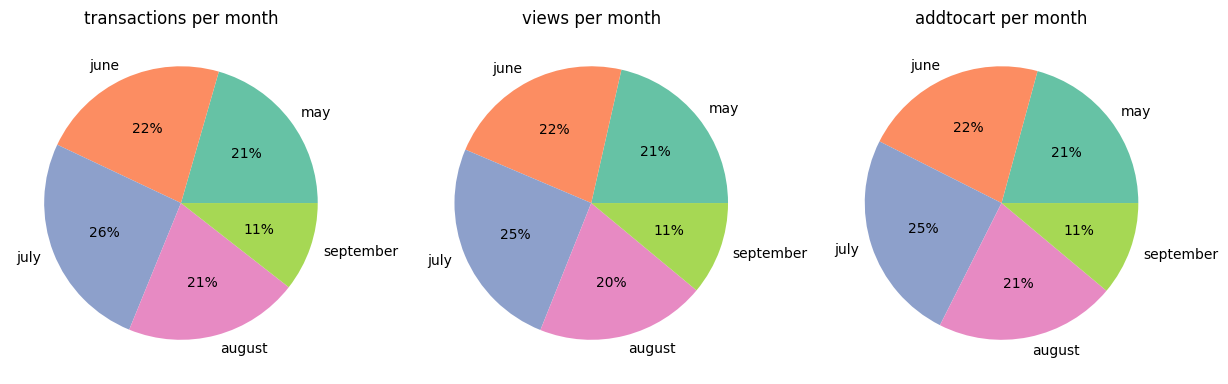

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].pie(events[events.event=='transaction'].groupby('month').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['may', 'june', 'july', 'august', 'september'],
        colors = sns.color_palette('Set2'),
        )
axes[0].set(title='transactions per month')


axes[1].pie(events[events.event=='view'].groupby('month').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['may', 'june', 'july', 'august', 'september'],
        colors = sns.color_palette('Set2'),
        )
axes[1].set(title='views per month')

axes[2].pie(events[events.event=='addtocart'].groupby('month').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['may', 'june', 'july', 'august', 'september'],
        colors = sns.color_palette('Set2'),
        )
axes[2].set(title='addtocart per month');

**Вывод:** Количество транзакций, добавления в корзину и просмотров примерно одинаково по месяцам. Однако наблюдается небольшой рост в июле.

#### 2.2.2. Распределение событий по дням недели.

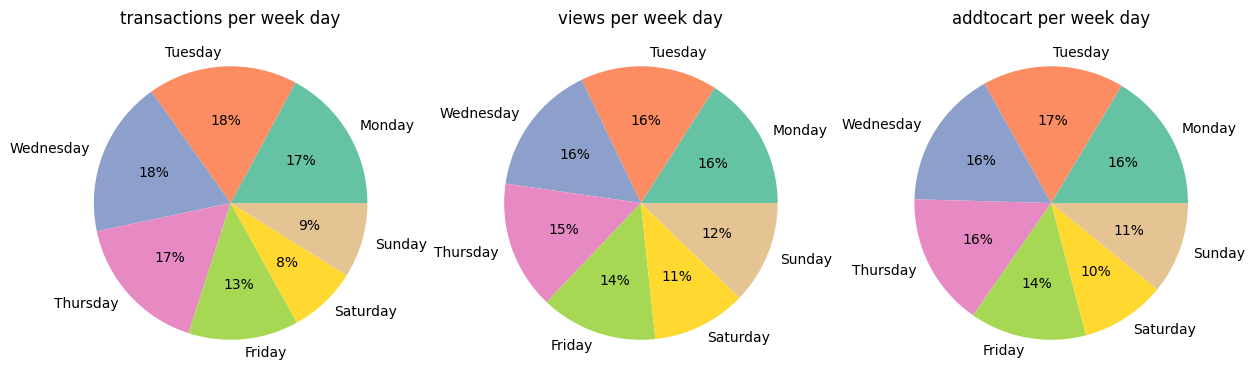

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].pie(events[events.event=='transaction'].groupby('dayofweek').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        colors = sns.color_palette('Set2'),
        )
axes[0].set(title='transactions per week day')


axes[1].pie(events[events.event=='view'].groupby('dayofweek').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        colors = sns.color_palette('Set2'),
        )
axes[1].set(title='views per week day')

axes[2].pie(events[events.event=='addtocart'].groupby('dayofweek').count()['timestamp'], 
        autopct='%.0f%%',
        labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
        colors = sns.color_palette('Set2'),
        )
axes[2].set(title='addtocart per week day');

**Вывод:** Из графиков видно, что наибольшую активность пользователи проявляют в первые четыре дня недели.

#### 2.2.3. Распределение событий по времени суток.

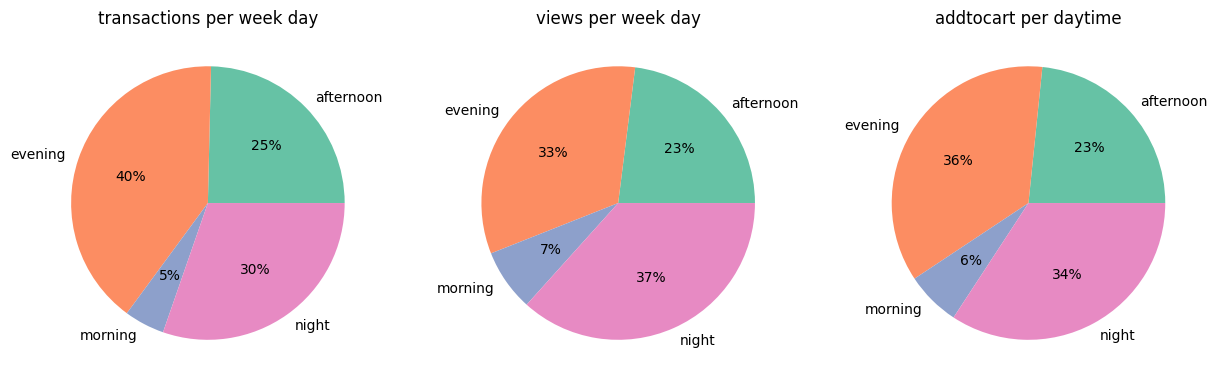

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].pie(events[events.event=='transaction'].groupby('time_of_day').count()['timestamp'], 
        autopct='%.0f%%',
        labels=events[events.event=='transaction'].groupby('time_of_day').count()['timestamp'].index,
        colors = sns.color_palette('Set2'),
        )
axes[0].set(title='transactions per week day')


axes[1].pie(events[events.event=='view'].groupby('time_of_day').count()['timestamp'], 
        autopct='%.0f%%',
        labels=events[events.event=='transaction'].groupby('time_of_day').count()['timestamp'].index,
        colors = sns.color_palette('Set2'),
        )
axes[1].set(title='views per week day')

axes[2].pie(events[events.event=='addtocart'].groupby('time_of_day').count()['timestamp'], 
        autopct='%.0f%%',
        labels=events[events.event=='transaction'].groupby('time_of_day').count()['timestamp'].index,
        colors = sns.color_palette('Set2'),
        )
axes[2].set(title='addtocart per daytime');

**Вывод:** Из графиков видно, что наибольшую активность пользователи проявляют вечером и ночью. Наименьшая активность приходится на утро.

#### 2.2.4. Распределение событий по месяцам.

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2374063656.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data = events.groupby(['month', 'event']).count()['timestamp'].reset_index(),
C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2374063656.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set(title='events per month', xticklabels=['may', 'june', 'july', 'august', 'september'], ylabel='count');


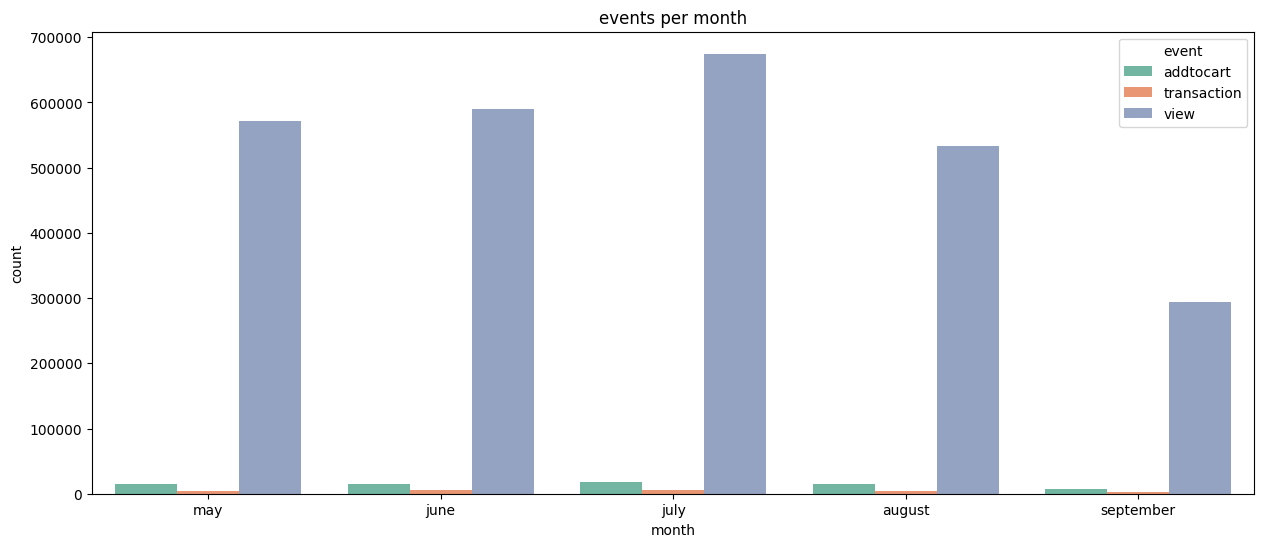

In [45]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

sns.barplot(data = events.groupby(['month', 'event']).count()['timestamp'].reset_index(), 
        x='month',
        y='timestamp',
        hue='event',
        palette=sns.color_palette('Set2')
        )
axes.set(title='events per month', xticklabels=['may', 'june', 'july', 'august', 'september'], ylabel='count');

**Вывод:** Количество просмотров в десятки раз превышает количество добавления в корзину. Количество продаж приверно в 2-3 раза меньше количества добавления товаров в корзину. 

#### 2.2.5. Распределение событий по дням недели.

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\3994005874.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data = events.groupby(['dayofweek', 'event']).count()['timestamp'].reset_index(),
C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\3994005874.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set(title='events per month', xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ylabel='count');


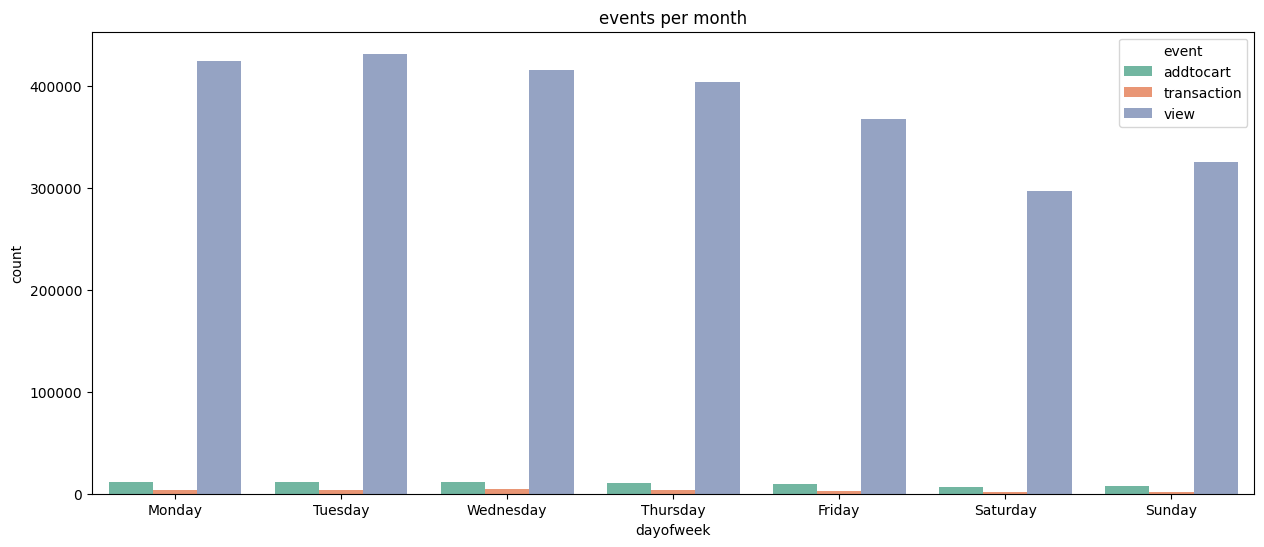

In [46]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

sns.barplot(data = events.groupby(['dayofweek', 'event']).count()['timestamp'].reset_index(), 
        x='dayofweek',
        y='timestamp',
        hue='event',
        palette=sns.color_palette('Set2')
        )
axes.set(title='events per month', xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ylabel='count');

**Вывод:** Соотношение продаж, добавления в корзину и просмотров примерно аналогично предыдущему графику.

#### 2.2.6. Распределение событий по времени суток.

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2704729178.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data = events.groupby(['time_of_day', 'event']).count()['timestamp'].reset_index(),


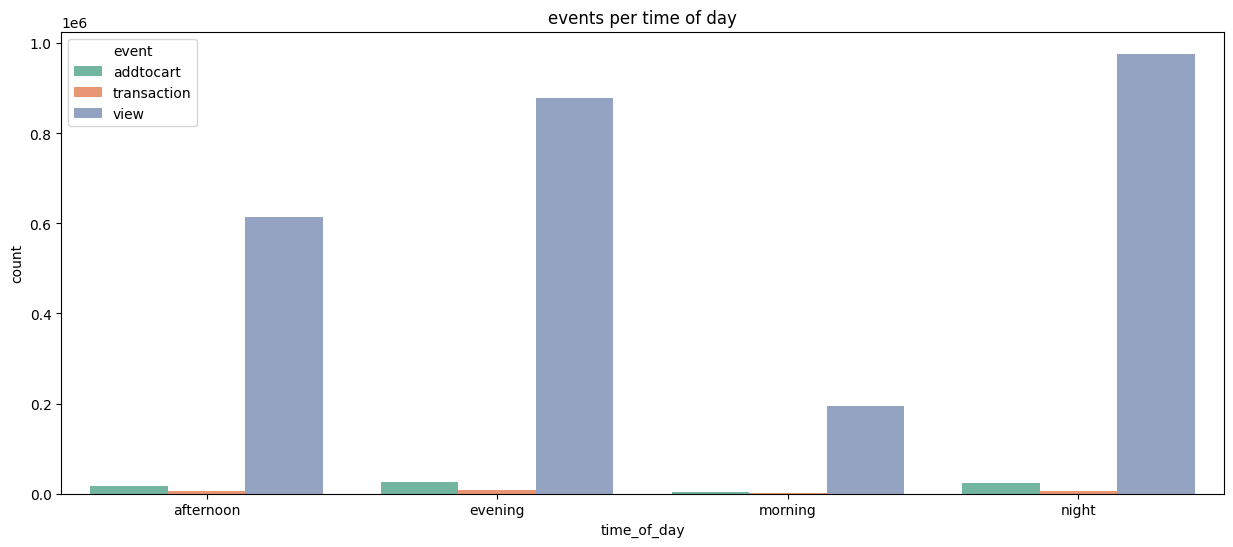

In [47]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

sns.barplot(data = events.groupby(['time_of_day', 'event']).count()['timestamp'].reset_index(), 
        x='time_of_day',
        y='timestamp',
        hue='event',
        palette=sns.color_palette('Set2')
        )
axes.set(title='events per time of day', ylabel='count');

**Вывод:** Из графика видно что на утро приходится наименьшая активность пользователей, но судя по всему, и отношение просмотров к продажам так же меньше утром. 

#### 2.2.7. Соотношение пользователей, купивших товар, с общим количеством пользователей.

In [48]:
buyers_id = events[events.event =='transaction'].visitorid.unique()
len(buyers_id)

11719

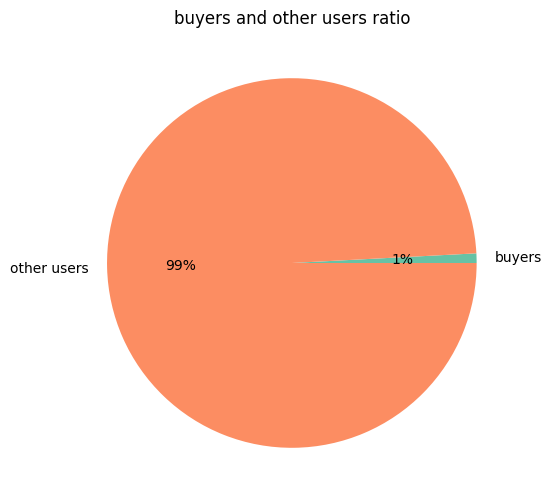

In [49]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

plt.pie([len(buyers_id), len(events.visitorid.unique())-len(buyers_id)], 
        autopct='%.0f%%',
        labels=['buyers', 'other users'],
        colors = sns.color_palette('Set2'),
        )
axes.set(title='buyers and other users ratio');

**Вывод:** Из соотношениея видн, что количестов пользователей, совершающих покупку не превышает 1%.

#### 2.2.8. Соотношение событий для 15 пользователей, купивших товар хотя бы один раз.

In [50]:
buyers = events[events.visitorid.isin(buyers_id[:16])].groupby(['visitorid', 'event']).count()['timestamp'].reset_index()
buyers.head()

,visitorid,event,timestamp
0,61806,addtocart,1
1,61806,transaction,1
2,61806,view,5
3,102019,addtocart,1
4,102019,transaction,2


C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2938385626.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data = buyers,


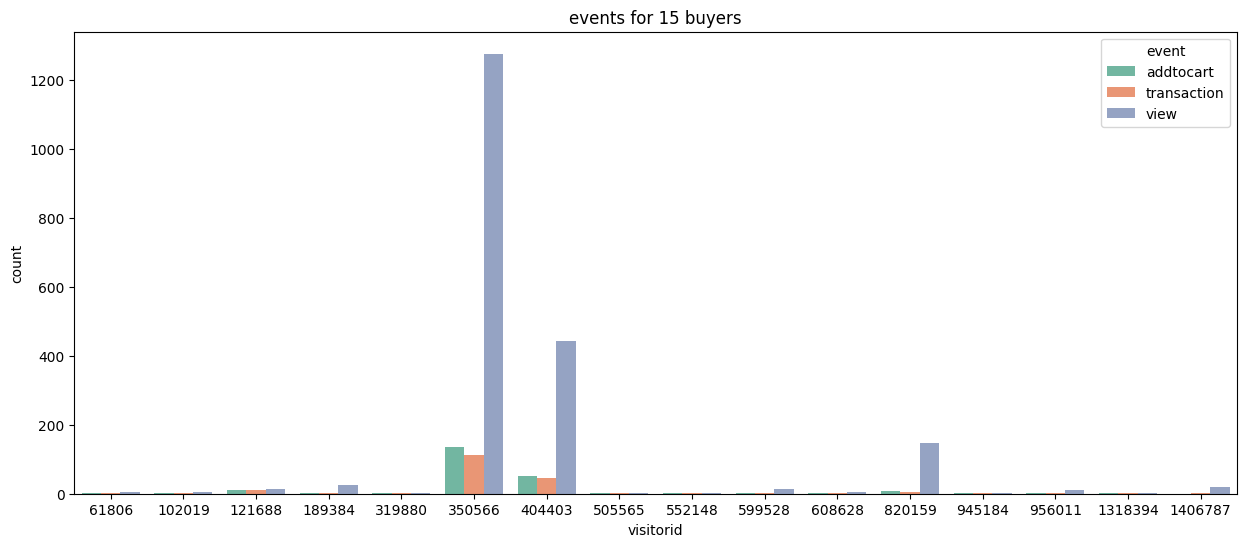

In [51]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

sns.barplot(data = buyers, 
        x='visitorid',
        y='timestamp',
        hue='event',
        palette=sns.color_palette('Set2')
        )
axes.set(title='events for 15 buyers', ylabel='count');

**Вывод:** Из графика видно, что количество покупок и соотношение действий сильно разнится от пользователя к пользователю. Можно говорить об индивидуальном поведении пользователей.

#### 2.2.9. Соотношение покупаемых товаров к непокупаемым товарам. Соотношение покупаемых товаров к товарам добавляемым в корзину.

In [52]:
selled_item_id = events[events.event =='transaction'].itemid.unique()
added_item_id = events[events.event =='addtocart'].itemid.unique()
len(selled_item_id), len(added_item_id)

(12025, 23903)

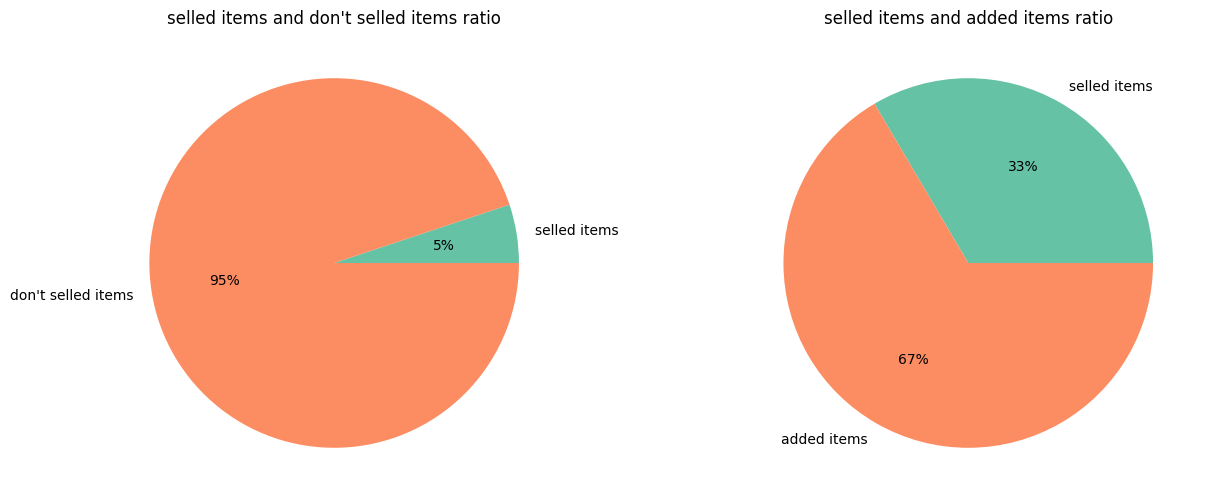

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].pie([len(selled_item_id), len(events.itemid.unique())-len(selled_item_id)], 
        autopct='%.0f%%',
        labels=['selled items', "don't selled items"],
        colors = sns.color_palette('Set2'),
        )
axes[0].set(title="selled items and don't selled items ratio");

axes[1].pie([len(selled_item_id), len(added_item_id)], 
        autopct='%.0f%%',
        labels=['selled items', "added items"],
        colors = sns.color_palette('Set2'),
        )
axes[1].set(title="selled items and added items ratio");

**Вывод:** Из графика видно что продается примерно 5% товаров. Только 33% типа товаров, добавленных в корзину выкупается покупателями.

#### 2.2.10. Соотношение событий для 15 товаров, купленных хотя бы один раз.

In [54]:
items = events[events.itemid.isin(selled_item_id[:16])].groupby(['itemid', 'event']).count()['timestamp'].reset_index()
items.head()

,itemid,event,timestamp
0,7943,addtocart,97
1,7943,transaction,46
2,7943,view,1346
3,15335,addtocart,1
4,15335,transaction,1


C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\1156040954.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(data = items,


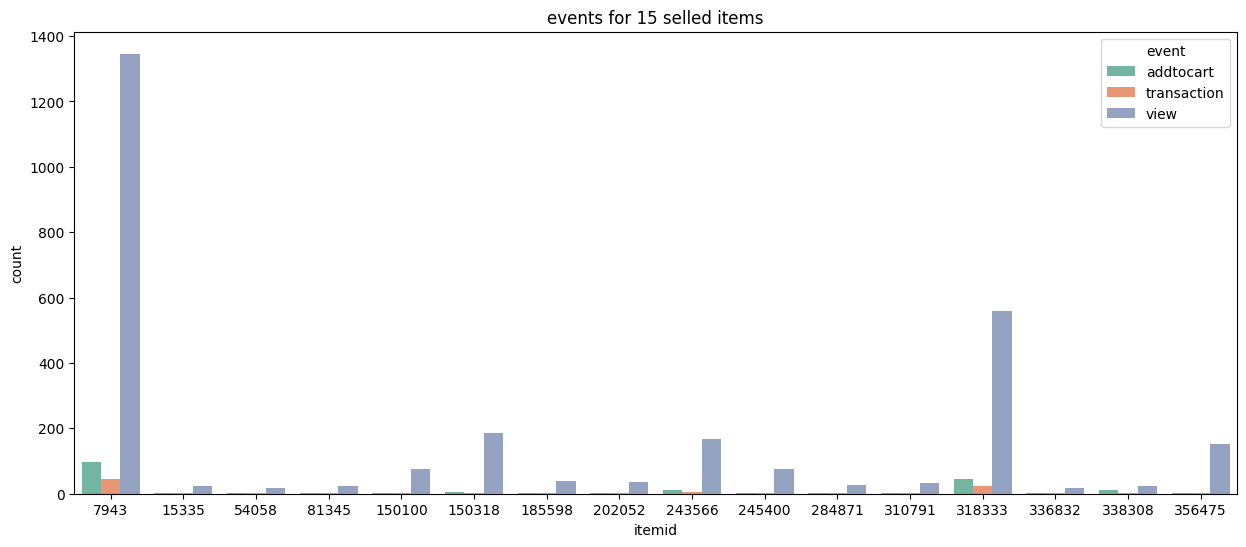

In [55]:
fig, axes = plt.subplots(nrows=1, figsize=(15, 6))

sns.barplot(data = items, 
        x='itemid',
        y='timestamp',
        hue='event',
        palette=sns.color_palette('Set2')
        )
axes.set(title='events for 15 selled items', ylabel='count');

**Вывод:** Из графика видно, что соотношение просмотров добавления в корзину и покупки примерно одинаково для разных продуктов. Надо отметить, что количество продаж, просмотров и добавления продуктов в корзину сильно различется в зависимости от товара.

## 3. Создание факторов для модели

Разобьем данные на тренировочную и тестовую выборки. Тестовую выборку возьмем 0.2 от общего числа записей.

In [56]:
events = events.sort_values('timestamp').reset_index(drop=True)
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,5,6,night
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,5,6,night
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,5,6,night
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,5,6,night
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,5,6,night


In [57]:
train_len = round(len(events.index)*0.8)
train_len

2204513

In [58]:
events_train = events.iloc[:train_len]
events_test = events.iloc[train_len:]
display(events_train.tail(), events_test.head())

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day
2204508,1439871762875,676819,view,229428,NaN,2015-08-18 04:22:42.875,8,1,night
2204509,1439871764694,521287,view,447661,NaN,2015-08-18 04:22:44.694,8,1,night
2204510,1439871775986,833642,view,327591,NaN,2015-08-18 04:22:55.986,8,1,night
2204511,1439871781129,1247038,view,193205,NaN,2015-08-18 04:23:01.129,8,1,night
2204512,1439871800445,803960,view,440937,NaN,2015-08-18 04:23:20.445,8,1,night


,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day
2204513,1439871802342,1063570,view,86466,NaN,2015-08-18 04:23:22.342,8,1,night
2204514,1439871802451,594784,view,214436,NaN,2015-08-18 04:23:22.451,8,1,night
2204515,1439871811966,526699,view,304858,NaN,2015-08-18 04:23:31.966,8,1,night
2204516,1439871817919,384670,view,419836,NaN,2015-08-18 04:23:37.919,8,1,night
2204517,1439871821714,1166298,view,375066,NaN,2015-08-18 04:23:41.714,8,1,night


### 3.1. Генерация факторов, связанных с айтемами

Создадим датафрейм items и добавим в него категории для товаров.

In [59]:
item_properties = item_properties[item_properties['property']=='categoryid'][['itemid', 'value']]
item_properties.head()

,itemid,value
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [60]:
item_properties.drop_duplicates(inplace=True)

In [61]:
item_properties.groupby('itemid').count().value.unique()

array([1, 2, 3, 4], dtype=int64)

In [62]:
item_properties['dupl'] = item_properties.itemid.duplicated()

In [63]:
item_properties_1 = item_properties[item_properties['dupl']==True].reset_index(drop=True)
item_properties_1['dupl'] = item_properties_1.itemid.duplicated()

item_properties_2 = item_properties_1[item_properties_1['dupl']==True].reset_index(drop=True)
item_properties_2['dupl'] = item_properties_2.itemid.duplicated()

item_properties_3 = item_properties_2[item_properties_2['dupl']==True].reset_index(drop=True)
item_properties_3['dupl'] = item_properties_3.itemid.duplicated()
item_properties_3['dupl'].sum()

0

In [64]:
items = item_properties[item_properties['dupl']==False].merge(item_properties_1[item_properties_1['dupl']==False], on='itemid', how='left', suffixes=('_0', '_1'))
items = items.merge(item_properties_2[item_properties_2['dupl']==False], on='itemid', how='left', suffixes=('_1', '_2'))
items = items.merge(item_properties_3[item_properties_3['dupl']==False], on='itemid', how='left', suffixes=('_2', '_3'))

items =  items[['itemid', 'value_0', 'value_1', 'value_2', 'value_3']]
items.reset_index(inplace=True, drop=True)

items.fillna(-1, inplace=True)

del item_properties, item_properties_1, item_properties_2, item_properties_3

items.head()

,itemid,value_0,value_1,value_2,value_3
0,460429,1338,-1,-1,-1
1,281245,1277,438,-1,-1
2,35575,1059,-1,-1,-1
3,8313,1147,1244,-1,-1
4,55102,47,381,-1,-1


In [65]:
items.value_0=items.value_0.astype(int)
items.value_1=items.value_1.astype(int)
items.value_2=items.value_2.astype(int)
items.value_3=items.value_3.astype(int)
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417053 entries, 0 to 417052
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   itemid   417053 non-null  int64
 1   value_0  417053 non-null  int32
 2   value_1  417053 non-null  int32
 3   value_2  417053 non-null  int32
 4   value_3  417053 non-null  int32
dtypes: int32(4), int64(1)
memory usage: 9.5 MB


Теперь добавим родительские категории для уже добавленых категорий товаров.

In [66]:
items_0 = items.merge(category_tree, left_on='value_0', right_on='categoryid', how='left', suffixes=('_0', '_1')).drop('categoryid', axis=1)
items_1 = items_0.merge(category_tree, left_on='value_1', right_on='categoryid', how='left', suffixes=('_1', '_2')).drop('categoryid', axis=1)
items_2 = items_1.merge(category_tree, left_on='value_1', right_on='categoryid', how='left', suffixes=('_2', '_3')).drop('categoryid', axis=1)
items_3 = items_2.merge(category_tree, left_on='value_1', right_on='categoryid', how='left', suffixes=('_3', '_4')).drop('categoryid', axis=1)
items = items_3

del items_0, items_1, items_2, items_3

In [67]:
items.rename(columns={'value_0': 'item_category_1',
                       'value_1': 'item_category_2',
                       'value_2': 'item_category_3',
                       'value_3': 'item_category_4',
                       'parentid_1': 'item_parent_category_1',
                       'parentid_2': 'item_parent_category_2',
                       'parentid_3': 'item_parent_category_3',
                       'parentid_4': 'item_parent_category_4'},
              inplace=True)

items.head()

,itemid,item_category_1,item_category_2,item_category_3,item_category_4,item_parent_category_1,item_parent_category_2,item_parent_category_3,item_parent_category_4
0,460429,1338,-1,-1,-1,1278.0,NaN,NaN,NaN
1,281245,1277,438,-1,-1,312.0,312.0,312.0,312.0
2,35575,1059,-1,-1,-1,1696.0,NaN,NaN,NaN
3,8313,1147,1244,-1,-1,1027.0,500.0,500.0,500.0
4,55102,47,381,-1,-1,381.0,1482.0,1482.0,1482.0


Добавим признак "с этим продуктом покупают". Для этого добвим 2 товара из чека на покупк, включающего выбраный товар.

In [68]:
buy_with = events_train[events_train.event=='transaction'][['transactionid', 'itemid', 'timestamp']].groupby(['transactionid', 'itemid']).count().reset_index()
buy_with.drop('timestamp', axis=1, inplace=True)

In [69]:
buy_with['dupl'] = buy_with.transactionid.duplicated()
buy_with_add = buy_with[buy_with['dupl']==True].groupby(['transactionid', 'itemid']).count().reset_index()
buy_with_add['dupl'] = buy_with_add.transactionid.duplicated()
buy_with_add.head()

,transactionid,itemid,dupl
0,12.0,432742,False
1,23.0,93556,False
2,23.0,351124,True
3,23.0,397642,True
4,27.0,272770,False


In [70]:
buy_with_first = buy_with_add[buy_with_add['dupl']==False].groupby('transactionid').first()
buy_with_first.drop('dupl', axis=1, inplace=True)
buy_with_first.reset_index(inplace=True)

buy_with_last = buy_with_add[buy_with_add['dupl']==True].groupby('transactionid').last()
buy_with_last.drop('dupl', axis=1, inplace=True)
buy_with_last.reset_index(inplace=True)

buy_with = buy_with[buy_with['dupl']==False]
buy_with = buy_with.merge(buy_with_first, on='transactionid', how='left', suffixes=('_0', '_1'))
buy_with = buy_with.merge(buy_with_last, on='transactionid', how='left', suffixes=('_1', '_2'))
buy_with.drop(['dupl', 'transactionid'], axis=1, inplace=True)
buy_with.fillna(-1, inplace=True)


In [71]:
buy_with.rename(columns={'itemid_0': 'itemid',
                       'itemid_1': 'buy_with_1',
                       'itemid': 'buy_with_2',},
              inplace=True)

In [72]:
items = items.merge(buy_with, on='itemid', how='left')
items.fillna(-1, inplace=True)

del buy_with

items.head()

,itemid,item_category_1,item_category_2,item_category_3,item_category_4,item_parent_category_1,item_parent_category_2,item_parent_category_3,item_parent_category_4,buy_with_1,buy_with_2
0,460429,1338,-1,-1,-1,1278.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,281245,1277,438,-1,-1,312.0,312.0,312.0,312.0,-1.0,-1.0
2,35575,1059,-1,-1,-1,1696.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,8313,1147,1244,-1,-1,1027.0,500.0,500.0,500.0,-1.0,-1.0
4,55102,47,381,-1,-1,381.0,1482.0,1482.0,1482.0,-1.0,-1.0


Создадим дадафрейм событий с добвалением информации от товарах.

In [73]:
events_train_feature = events_train.merge(items, on='itemid', how='left')

events_train_feature.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day,item_category_1,item_category_2,item_category_3,item_category_4,item_parent_category_1,item_parent_category_2,item_parent_category_3,item_parent_category_4,buy_with_1,buy_with_2
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,5,6,night,1130.0,-1.0,-1.0,-1.0,1323.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,5,6,night,463.0,-1.0,-1.0,-1.0,250.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,5,6,night,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,5,6,night,1628.0,-1.0,-1.0,-1.0,605.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,5,6,night,1130.0,-1.0,-1.0,-1.0,1323.0,-1.0,-1.0,-1.0,-1.0,-1.0


### 3.2. Генерация факторов айтем-юзер

Создадим датафрейм со списком пользователей и наиболее часто просматриваемым товаром для каждого пользователя.

In [74]:
users = events_train_feature[events_train_feature.event=='view'][['visitorid', 'itemid', 'timestamp']].groupby(['visitorid','itemid']).count().reset_index()
users = users.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'itemid']]

users.head()

,visitorid,itemid
0,1,72028
1,2,342816
2,3,385090
3,5,61396
4,7,226353


Добавим наиболее просматриваемую пользователем категорию.

In [75]:
users_cat = events_train_feature[events_train_feature.event=='view'][['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4', 'timestamp']].groupby(['visitorid', 'item_category_1', 
                                                                                  'item_category_2', 'item_category_3', 
                                                                                  'item_category_4'
                                                                                  ]).count().reset_index()
users_cat = users_cat.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4']]
users = users.merge(users_cat, on='visitorid', how='left')

del users_cat

users.head()

,visitorid,itemid,item_category_1,item_category_2,item_category_3,item_category_4
0,1,72028,1192.0,-1.0,-1.0,-1.0
1,2,342816,444.0,-1.0,-1.0,-1.0
2,3,385090,1171.0,-1.0,-1.0,-1.0
3,5,61396,646.0,-1.0,-1.0,-1.0
4,7,226353,1114.0,429.0,-1.0,-1.0


Добавим тавар, чаще всего добавляемый в корзину.

In [76]:
users_add_item = events_train_feature[events_train_feature.event=='addtocart'][['visitorid', 'itemid', 'timestamp']].groupby(['visitorid','itemid']).count().reset_index()
users_add_item = users_add_item.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'itemid']]

users = users.merge(users_add_item, on='visitorid', how='left', suffixes=('_viewed', '_added'))

del users_add_item

users.head()

,visitorid,itemid_viewed,item_category_1,item_category_2,item_category_3,item_category_4,itemid_added
0,1,72028,1192.0,-1.0,-1.0,-1.0,NaN
1,2,342816,444.0,-1.0,-1.0,-1.0,NaN
2,3,385090,1171.0,-1.0,-1.0,-1.0,NaN
3,5,61396,646.0,-1.0,-1.0,-1.0,NaN
4,7,226353,1114.0,429.0,-1.0,-1.0,NaN


Добавим категорию тавары из которой пользователь чаще всего добавляет в корзину.

In [77]:
users_cat = events_train_feature[events_train_feature.event=='addtocart'][['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4', 'timestamp']].groupby(['visitorid', 'item_category_1', 
                                                                                  'item_category_2', 'item_category_3', 
                                                                                  'item_category_4'
                                                                                  ]).count().reset_index()
users_cat = users_cat.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4']]
users = users.merge(users_cat, on='visitorid', how='left', suffixes=('_viewed', '_added'))

del users_cat

users.head()

,visitorid,itemid_viewed,item_category_1_viewed,item_category_2_viewed,item_category_3_viewed,item_category_4_viewed,itemid_added,item_category_1_added,item_category_2_added,item_category_3_added,item_category_4_added
0,1,72028,1192.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
1,2,342816,444.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
2,3,385090,1171.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
3,5,61396,646.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN
4,7,226353,1114.0,429.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN


Добавим чаще всего покупаемый пользователем товар.

In [78]:
users_trans_item = events_train_feature[events_train_feature.event=='transaction'][['visitorid', 'itemid', 'timestamp']].groupby(['visitorid','itemid']).count().reset_index()
users_trans_item = users_trans_item.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'itemid']]

users = users.merge(users_trans_item, on='visitorid', how='left', suffixes=(None, '_buyed'))

del users_trans_item

users.head()

,visitorid,itemid_viewed,item_category_1_viewed,item_category_2_viewed,item_category_3_viewed,item_category_4_viewed,itemid_added,item_category_1_added,item_category_2_added,item_category_3_added,item_category_4_added,itemid
0,1,72028,1192.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,342816,444.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,385090,1171.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,61396,646.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7,226353,1114.0,429.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN


Добавим категорию в которой пользователь чаще всего покупает товары.

In [79]:
users_cat = events_train_feature[events_train_feature.event=='transaction'][['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4', 'timestamp']].groupby(['visitorid', 'item_category_1', 
                                                                                  'item_category_2', 'item_category_3', 
                                                                                  'item_category_4'
                                                                                  ]).count().reset_index()
users_cat = users_cat.groupby('visitorid').max('timestamp').reset_index()[['visitorid', 'item_category_1', 
                                        'item_category_2', 'item_category_3', 
                                        'item_category_4']]
users = users.merge(users_cat, on='visitorid', how='left',)

users.rename(columns={'itemid': 'itemid_buyed',
                       'item_category_1': 'item_category_1_buyed',
                       'item_category_2': 'item_category_2_buyed',
                       'item_category_3': 'item_category_3_buyed',
                       'item_category_4': 'item_category_4_buyed',
                       },
                        inplace=True)

del users_cat

users.head()

,visitorid,itemid_viewed,item_category_1_viewed,item_category_2_viewed,item_category_3_viewed,item_category_4_viewed,itemid_added,item_category_1_added,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed
0,1,72028,1192.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,342816,444.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,385090,1171.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,61396,646.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,226353,1114.0,429.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим время наибольшей активности и день недели наибольшей актовности пользователя.

In [80]:
daytime = events_train_feature[['visitorid', 'time_of_day', 'timestamp'
                  ]].groupby(['visitorid', 'time_of_day']).count().reset_index()
daytime.groupby('visitorid').max().reset_index()
users = users.merge(daytime[['visitorid', 'time_of_day']], on='visitorid', how='left')

users.head()

,visitorid,itemid_viewed,item_category_1_viewed,item_category_2_viewed,item_category_3_viewed,item_category_4_viewed,itemid_added,item_category_1_added,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day
0,1,72028,1192.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,afternoon
1,2,342816,444.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,afternoon
2,2,342816,444.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,evening
3,3,385090,1171.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,morning
4,5,61396,646.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,night


In [81]:
daytime = events_train_feature[['visitorid', 'dayofweek', 'timestamp'
                  ]].groupby(['visitorid', 'dayofweek']).count().reset_index()
daytime.groupby('visitorid').max().reset_index()
users = users.merge(daytime[['visitorid', 'dayofweek']], on='visitorid', how='left')
users.rename(columns={'time_of_day': 'time_of_day_favorite',
                       'dayofweek': 'dayofweek_favorite'},
              inplace=True)
users.fillna(-1, inplace=True)

del daytime

users.head()

,visitorid,itemid_viewed,item_category_1_viewed,item_category_2_viewed,item_category_3_viewed,item_category_4_viewed,itemid_added,item_category_1_added,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day_favorite,dayofweek_favorite
0,1,72028,1192.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,afternoon,3
1,2,342816,444.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,afternoon,4
2,2,342816,444.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,evening,4
3,3,385090,1171.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,morning,5
4,5,61396,646.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,4


Добавим признаки в датафрейм событий.

In [82]:
events_train_feature = events_train_feature.merge(users, on='visitorid', how='left')

events_train_feature.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day,item_category_1,...,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day_favorite,dayofweek_favorite
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,5,6,night,1130.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,5,6,night,463.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,5,6,night,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,5,6,night,1628.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,5,6,night,1130.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0


In [83]:
events_train_feature[events_train_feature.visitorid==172330]

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day,item_category_1,...,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day_favorite,dayofweek_favorite
15915050,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15915051,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15915052,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15915053,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15915054,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15915055,1439867343052,172330,addtocart,325852,NaN,2015-08-18 03:09:03.052,8,1,night,342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3. Перечень созданных признаков

**items — признаки товара**   
**Колонки:**  
- *itemid* — идентификатор объекта 
- *item_category_1* — первая категория товаров
- *item_category_2* — вторая категория товаров
- *item_category_3* — третья категория товаров
- *item_category_4* — четвертая категория товаров
- *item_parent_category_1* — родительская категория первой категории товаров
- *item_parent_category_2* — родительская категория второй категории товаров
- *item_parent_category_3* — родительская категория третьей категории товаров
- *item_parent_category_4* — родительская категория четвертой категории товаров
- *buy_with_1* — первый сопутствующий товар
- *buy_with_2* — второй сопутствующий товар

**users — характеристики пользователя**   
**Колонки:**  
- *visitorid* — идентификатор пользователя 
- *itemid_viewed* — наиболее просматириваемый пользователем товар 
- *item_category_1_viewed* — первая наиболее просматриваемая категория товаров
- *item_category_2_viewed* — вторая наиболее просматриваемая категория товаров
- *item_category_3_viewed* — третья наиболее просматриваемая категория товаров
- *item_category_4_viewed* — четвертая наиболее просматриваемая категория товаров
- *itemid_added* — товар, чаще всего добавляемый пользователем в корзину 
- *item_category_1_added* — первая категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_2_added* — вторая категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_3_added* — третья категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_4_added* — четвертая категория товара, чаще всего добавляемый пользователем в корзину
- *itemid_buyed* — чаще всего покупаемый товар
- *item_category_1_buyed* — первая чаще всего покупаемая категория товаров
- *item_category_2_buyed* — вторая чаще всего покупаемая категория товаров
- *item_category_3_buyed* — третья чаще всего покупаемая категория товаров
- *item_category_4_buyed* — четвертая чаще всего покупаемая категория товаров
- *time_of_day_favorite* — время наибольшей активности пользователя
- *dayofweek_favorite* — день недели наибольшей активности пользователя


**events_train_feature — тренировочный датасет с событиями и признаками товаров и пользователей.**   
**Колонки:**  
- *timestamp* — время события
- *visitorid* — идентификатор пользователя
- *event* — тип события
    - *view* (просмотр карточки товара)  
    - *addtocart* (добавление в корзину)  
    - *transaction* (покупка)
- *itemid* — идентификатор объекта
- *transactionid* — идентификатор транзакции, если она проходила  
- *item_category_1* — первая категория товаров
- *item_category_2* — вторая категория товаров
- *item_category_3* — третья категория товаров
- *item_category_4* — четвертая категория товаров
- *item_parent_category_1* — родительская категория первой категории товаров
- *item_parent_category_2* — родительская категория второй категории товаров
- *item_parent_category_3* — родительская категория третьей категории товаров
- *item_parent_category_4* — родительская категория четвертой категории товаров
- *buy_with_1* — первый сопутствующий товар
- *buy_with_2* — второй сопутствующий товар
- *visitorid* — идентификатор пользователя 
- *itemid_viewed* — наиболее просматириваемый пользователем товар 
- *item_category_1_viewed* — первая наиболее просматриваемая категория товаров
- *item_category_2_viewed* — вторая наиболее просматриваемая категория товаров
- *item_category_3_viewed* — третья наиболее просматриваемая категория товаров
- *item_category_4_viewed* — четвертая наиболее просматриваемая категория товаров
- *itemid_added* — товар, чаще всего добавляемый пользователем в корзину 
- *item_category_1_added* — первая категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_2_added* — вторая категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_3_added* — третья категория товара, чаще всего добавляемый пользователем в корзину
- *item_category_4_added* — четвертая категория товара, чаще всего добавляемый пользователем в корзину
- *itemid_buyed* — чаще всего покупаемый товар
- *item_category_1_buyed* — первая чаще всего покупаемая категория товаров
- *item_category_2_buyed* — вторая чаще всего покупаемая категория товаров
- *item_category_3_buyed* — третья чаще всего покупаемая категория товаров
- *item_category_4_buyed* — четвертая чаще всего покупаемая категория товаров
- *time_of_day_favorite* — время наибольшей активности пользователя
- *dayofweek_favorite* — день недели наибольшей активности пользователя


### 3.4. Рейтинг товаров

Предлагаю принять покупку товара как 10 баллов, добавление в корзину как 5 баллов и просмотр как 1 балл. Так же введем поправочные коэффициенты для категорий и родительских категорий товаров.

In [84]:
event_dict = {'view':1, 'addtocart':5,'transaction':10}

cat_coef = 0.1
parent_cat_coef = 0.01

In [85]:
events_train_feature.event = events_train_feature.event.apply(lambda x: event_dict[x])
events_train_feature.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,month,dayofweek,time_of_day,item_category_1,...,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day_favorite,dayofweek_favorite
0,1430622004384,693516,5,297662,NaN,2015-05-03 03:00:04.384,5,6,night,1130.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
1,1430622011289,829044,1,60987,NaN,2015-05-03 03:00:11.289,5,6,night,463.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
2,1430622013048,652699,1,252860,NaN,2015-05-03 03:00:13.048,5,6,night,NaN,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
3,1430622024154,1125936,1,33661,NaN,2015-05-03 03:00:24.154,5,6,night,1628.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
4,1430622026228,693516,1,297662,NaN,2015-05-03 03:00:26.228,5,6,night,1130.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0


Создадим датафрейм с рейтингом товаров пользователей.

In [86]:
rating = events_train_feature[['visitorid', 'itemid', 'event']].groupby(['visitorid', 'itemid']).mean().reset_index()
rating.rename(columns={'event': 'item_rating'}, inplace=True)
rating.head()

,visitorid,itemid,item_rating
0,1,72028,1.0
1,2,216305,1.0
2,2,259884,1.0
3,2,325215,1.0
4,2,342816,1.0


Теперь определим рейтинг по категориям наиболее добавляемых в корзину и наиболее покупаемых товаров. Поправочный коэфициент к категориям возьмем cat_coef.

In [87]:
# Добавленые в корзину товары
cat_added_rating  = pd.lreshape(events_train_feature[['visitorid', 'item_category_1_added', 
                                  'item_category_2_added', 'item_category_3_added', 
                                  'item_category_4_added']], {'item_category': ['item_category_1_added', 'item_category_2_added', 
                                                                       'item_category_3_added', 'item_category_4_added']})
cat_added_rating = cat_added_rating[cat_added_rating.item_category!=-1]
cat_added_rating.drop_duplicates(inplace=True)
# cat_added_rating.dropna(how='any', inplace=True)
cat_added_rating = cat_added_rating.astype('int32')

# Купленые товары
cat_buyed_rating  = pd.lreshape(events_train_feature[['visitorid', 'item_category_1_buyed', 
                                  'item_category_2_buyed', 'item_category_3_buyed', 
                                  'item_category_4_buyed']], {'item_category': ['item_category_1_buyed', 'item_category_2_buyed', 
                                                                       'item_category_3_buyed', 'item_category_4_buyed']})
cat_buyed_rating = cat_buyed_rating[cat_buyed_rating.item_category!=-1]
cat_buyed_rating.drop_duplicates(inplace=True)
# cat_buyed_rating.dropna(how='any', inplace=True)
cat_buyed_rating = cat_buyed_rating.astype('int32')

display( cat_added_rating.head(), cat_buyed_rating.head())

,visitorid,item_category
0,693516,1130
32,260113,1089
37,90447,1645
40,979664,84
95,41386,985


,visitorid,item_category
95,41386,985
679,560305,342
1301,266417,470
1303,869008,1542
1645,1086108,1542


In [88]:
items_cat = pd.lreshape(items[['itemid', 'item_category_1', 
                                  'item_category_2', 'item_category_3', 
                                  'item_category_4']], {'item_category': ['item_category_1', 'item_category_2', 
                                                                       'item_category_3', 'item_category_4']})
items_cat = items_cat[items_cat.item_category!=-1] 
items_cat = items_cat.astype('int32')
items_cat.head()

,itemid,item_category
0,460429,1338
1,281245,1277
2,35575,1059
3,8313,1147
4,55102,47


In [89]:
cat_added_rating = cat_added_rating.merge(items_cat, on='item_category', how='outer')
cat_added_rating.dropna(inplace=True)
cat_added_rating.drop('item_category', axis=1, inplace=True)
cat_added_rating.drop_duplicates(inplace=True)
cat_added_rating['cat_rating_added'] =cat_coef * 5

cat_buyed_rating = cat_buyed_rating.merge(items_cat, on='item_category', how='outer')
cat_buyed_rating.dropna(inplace=True)
cat_buyed_rating.drop('item_category', axis=1, inplace=True)
cat_buyed_rating.drop_duplicates(inplace=True)
cat_buyed_rating['cat_rating_buyed'] =cat_coef * 10

display(cat_added_rating.head(), cat_buyed_rating.head())

,visitorid,itemid,cat_rating_added
0,220439.0,1957,0.5
1,220439.0,207072,0.5
2,220439.0,347416,0.5
3,220439.0,458345,0.5
4,220439.0,167416,0.5


,visitorid,itemid,cat_rating_buyed
0,743285.0,1957,1.0
1,743285.0,207072,1.0
2,743285.0,347416,1.0
3,743285.0,458345,1.0
4,743285.0,167416,1.0


In [90]:
rating = rating.merge(cat_added_rating, on=['itemid', 'visitorid'], how='outer')
rating = rating.merge(cat_buyed_rating, on=['itemid', 'visitorid'], how='outer')
rating = rating.groupby(['visitorid', 'itemid']).mean().reset_index()
rating.head()

,visitorid,itemid,item_rating,cat_rating_added,cat_rating_buyed
0,1.0,72028,1.0,NaN,NaN
1,2.0,216305,1.0,NaN,NaN
2,2.0,259884,1.0,NaN,NaN
3,2.0,325215,1.0,NaN,NaN
4,2.0,342816,1.0,NaN,NaN


In [91]:
del items_cat

Теперь определим рейтинг по родительским категориям для купленых пользователем товаров. . Поправочный коэфициент к категориям возьмем parent_cat_coef.

In [92]:
# Добавленые в корзину товары
parent_added_rating = cat_added_rating[['visitorid', 'itemid']]
parent_added_rating.drop_duplicates(inplace=True)

# Купленые товары
parent_buyed_rating = cat_buyed_rating[['visitorid', 'itemid']]
parent_buyed_rating.drop_duplicates(inplace=True)

del cat_added_rating, cat_buyed_rating

display(parent_added_rating.head(), parent_buyed_rating.head())

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2188017122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_added_rating.drop_duplicates(inplace=True)
C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\2188017122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parent_buyed_rating.drop_duplicates(inplace=True)


,visitorid,itemid
0,220439.0,1957
1,220439.0,207072
2,220439.0,347416
3,220439.0,458345
4,220439.0,167416


,visitorid,itemid
0,743285.0,1957
1,743285.0,207072
2,743285.0,347416
3,743285.0,458345
4,743285.0,167416


Найдем родительские категории для всех товаров.

In [93]:
# Родительские категории товаров
items_parent_cat  = pd.lreshape(items[['itemid', 'item_parent_category_1', 
                                  'item_parent_category_2', 'item_parent_category_3', 
                                  'item_parent_category_4']], {'item_parent_category': ['item_parent_category_1', 'item_parent_category_2', 
                                                                       'item_parent_category_3', 'item_parent_category_4']})
items_parent_cat.drop_duplicates(inplace=True)
# cat_added_rating.dropna(how='any', inplace=True)
items_parent_cat = items_parent_cat[items_parent_cat.item_parent_category!=-1] 
items_parent_cat = items_parent_cat.astype('int32')
items_parent_cat


,itemid,item_parent_category
0,460429,1278
1,281245,312
2,35575,1696
3,8313,1027
4,55102,381
...,...,...
814297,426143,593
816728,203686,593
820304,375965,713
823907,39694,164


Найдем любимые родительские категории для пользователей.

In [94]:
parent_added_rating = parent_added_rating.merge(items_parent_cat, on='itemid', how='outer')
parent_added_rating = parent_added_rating[['visitorid', 'item_parent_category']].drop_duplicates()
parent_buyed_rating = parent_buyed_rating.merge(items_parent_cat, on='itemid', how='outer')
parent_buyed_rating = parent_buyed_rating[['visitorid', 'item_parent_category']].drop_duplicates()

display(parent_added_rating.head(), parent_buyed_rating.head())

,visitorid,item_parent_category
0,398295.0,293
1,1400525.0,293
2,1247721.0,293
3,889407.0,293
4,209591.0,293


,visitorid,item_parent_category
0,1247721.0,293
1,889407.0,293
2,209591.0,293
3,725579.0,293
4,228610.0,293


Долбавим рейтинг для товаров родительских категориях.

In [95]:
parent_added_rating = parent_added_rating.merge(items_parent_cat, on='item_parent_category', how='outer')
parent_added_rating.dropna(inplace=True)
parent_added_rating.drop('item_parent_category', axis=1, inplace=True)
parent_added_rating.drop_duplicates(inplace=True)
parent_added_rating['parent_cat_rating_added'] =parent_cat_coef * 5

parent_buyed_rating = parent_buyed_rating.merge(items_parent_cat, on='item_parent_category', how='outer')
parent_buyed_rating.dropna(inplace=True)
parent_buyed_rating.drop('item_parent_category', axis=1, inplace=True)
parent_buyed_rating.drop_duplicates(inplace=True)
parent_buyed_rating['parent_cat_rating_buyed'] =parent_cat_coef * 10

display(parent_added_rating.head(), parent_buyed_rating.head())

,visitorid,itemid,parent_cat_rating_added
1166,544462.0,274421,0.05
1167,544462.0,118383,0.05
1168,544462.0,14612,0.05
1169,544462.0,426904,0.05
1170,544462.0,283478,0.05


,visitorid,itemid,parent_cat_rating_buyed
1166,198045.0,274421,0.1
1167,198045.0,118383,0.1
1168,198045.0,14612,0.1
1169,198045.0,426904,0.1
1170,198045.0,283478,0.1


In [96]:
rating = rating.merge(parent_added_rating, on=['itemid', 'visitorid'], how='left')
rating = rating.merge(parent_buyed_rating, on=['itemid', 'visitorid'], how='left')
rating = rating.groupby(['visitorid', 'itemid']).mean().reset_index()
rating.head()

,visitorid,itemid,item_rating,cat_rating_added,cat_rating_buyed,parent_cat_rating_added,parent_cat_rating_buyed
0,1.0,72028,1.0,NaN,NaN,NaN,NaN
1,2.0,216305,1.0,NaN,NaN,NaN,NaN
2,2.0,259884,1.0,NaN,NaN,NaN,NaN
3,2.0,325215,1.0,NaN,NaN,NaN,NaN
4,2.0,342816,1.0,NaN,NaN,NaN,NaN


In [97]:
rating = rating.fillna(0)
rating['rating_total'] = rating.item_rating + rating.cat_rating_added \
+ rating.cat_rating_buyed + rating.parent_cat_rating_added + rating.parent_cat_rating_buyed
rating.drop(['item_rating', 'cat_rating_added', 'cat_rating_buyed', 'parent_cat_rating_added', 'parent_cat_rating_buyed'], axis=1, inplace=True)

del parent_added_rating, parent_buyed_rating

rating.head()

,visitorid,itemid,rating_total
0,1.0,72028,1.0
1,2.0,216305,1.0
2,2.0,259884,1.0
3,2.0,325215,1.0
4,2.0,342816,1.0


## 4. Проведение экспериментов

### 4.1. Коллаборативная фильтрация

Так как объем данных получается слишком большим предлагаю использовать только те данные по пользователям и товарам, гдетовар добавляется в корзину или совершается покупка.

In [98]:
dataset = rating[rating.rating_total>2].rename(columns={
    "visitorid": "userID",
    "itemid": "itemID", 
    'rating_total':'rating'
})

In [99]:
reader = Reader(rating_scale=(rating.rating_total.min(), rating.rating_total.max()))
data = Dataset.load_from_df(dataset, reader)
trainset = data.build_full_trainset()

In [100]:
param_grid = {
    'k': [10, 30, 40, 50, 100],
    'min_k ': [2, 3, 10],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [1, 5],
        'user_based': [True],
        'random_state': [42]
    },
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["mae"], cv=3)

In [101]:
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

In [102]:
print('Лучшие параметры для алгоритма коллаборативной фильтрации:', gs.best_params["mae"])

Лучшие параметры для алгоритма коллаборативной фильтрации: {'k': 10, 'min_k ': 2, 'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': True, 'random_state': 42}}


In [103]:
model = KNNWithMeans(**gs.best_params["mae"])
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [104]:
test_data = events_test.copy()
test_data['event'] = test_data.event.apply(lambda x: event_dict[x])
test_data = test_data[['visitorid', 'itemid', 'event']].rename(columns={
    "visitorid": "userID",
    "itemid": "itemID", 
    'event':'rating'
})
test_data

test_data = Dataset.load_from_df(test_data, reader)
test_data = test_data.build_full_trainset().build_testset()

Метрику предлагаю считать по клиентам, которые купили хотябы один товар.

In [105]:
# predictions = algo.test(test_data)
result = pd.DataFrame(columns=['visitorid', 'itemid', 'score'])
for us in events_test[events_test.event == 'transaction'].visitorid.unique():
    users_list =[]
    items_list =[]
    score_list =[]
    for it in events_test.itemid.unique():
        prediction = model.predict(us, it)
        users_list.append(prediction[0])
        items_list.append(prediction[1])
        score_list.append(prediction[3])
        # print(algo.predict(us, it))
    result = pd.concat([result, pd.DataFrame({'visitorid': users_list, 'itemid': items_list, 'score': score_list}).nlargest(3, 'score')], axis=0, ignore_index=True)
result

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\1510545893.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, pd.DataFrame({'visitorid': users_list, 'itemid': items_list, 'score': score_list}).nlargest(3, 'score')], axis=0, ignore_index=True)


,visitorid,itemid,score
0,873157,86466,4.030587
1,873157,214436,4.030587
2,873157,304858,4.030587
3,1183970,86466,4.030587
4,1183970,214436,4.030587
...,...,...,...
7405,62004,214436,4.030587
7406,62004,304858,4.030587
7407,427756,86466,4.030587
7408,427756,214436,4.030587


In [106]:
collab_presission = result.merge(events_test[events_test.event == 'transaction'][['visitorid', 'itemid', 'event']], 
             on=['visitorid', 'itemid'], how='left')
collab_presission.head()

,visitorid,itemid,score,event
0,873157,86466,4.030587,NaN
1,873157,214436,4.030587,NaN
2,873157,304858,4.030587,NaN
3,1183970,86466,4.030587,NaN
4,1183970,214436,4.030587,NaN


In [107]:
collab_presission = len(collab_presission[collab_presission.event =='transaction'])/len(collab_presission.index)
print('Метрика Presission@3 для коллаборативной фильтрации: ',  collab_presission)

Метрика Presission@3 для коллаборативной фильтрации:  0.001349345567399811


In [108]:
with open('collab_model.pickle', 'wb') as f:
    pickle.dump(model, f)

with open('collab_dataset.pickle', 'wb') as f:
    pickle.dump(dataset, f)

In [109]:
del dataset, test_data, result

### 4.2. Факторизационные машины

Генерируем сводную таблицу для обучения факторизационной машины.

In [110]:
train_pivot = rating[rating.rating_total>3].reset_index().pivot_table(
    index="visitorid", 
    columns="itemid", 
    values="rating_total", 
    aggfunc='mean'
)
train_pivot = train_pivot.fillna(0)
train_pivot.head()

itemid,15,19,25,33,42,66,147,199,212,216,...,466443,466526,466539,466614,466710,466726,466740,466844,466861,466864
visitorid,,,,,,,,,,,,,,,,,,,,,
172.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)

Определяем параметры маодели для подбора и проверяем на метрике Presission@3.

In [112]:
param_grid = {
    'no_components': [1, 5, 10, 25, 50, 100],
    'loss': ['logistic']
    }

In [113]:
item_ids = np.arange(0, train_pivot_sparse.shape[1])
unique_items = np.array(train_pivot.columns)

users_dict = dict(zip(train_pivot.index, list(range(len(train_pivot.index)))))
val_users = list(set(rating[rating.rating_total>3].visitorid.unique()).intersection(events_test[events_test.event == 'transaction'].visitorid.unique()))

max_presission = 0
learning_dict ={'no_components':[], 'loss':[], 'presission':[]}

In [114]:
for comp in param_grid['no_components']:
    for l in param_grid['loss']:
        learning_dict['no_components'].append(comp)
        learning_dict['loss'].append(l)
        model = LightFM(no_components=comp, loss=l, random_state=42)
        model.fit(train_pivot_sparse, epochs=30)
        
        result = pd.DataFrame(columns=['visitorid', 'itemid'])
        for us in val_users:
            list_pred = model.predict(users_dict[us], item_ids)
            recomendations_ids = np.argsort(-list_pred)[:3]
            # recomendations = unique_items[recomendations_ids]
            result = pd.concat([result, pd.DataFrame({'visitorid': [users_dict[us]]*3,  'itemid': recomendations_ids})], axis=0, ignore_index=True)
        fact_presission = result.merge(events_test[events_test.event=='transaction'][['visitorid', 'itemid', 'event']], 
                 on=['visitorid', 'itemid'], how='left')
        fact_presission = len(fact_presission[fact_presission.event=='transaction'])/len(result.index)
        learning_dict['presission'].append(fact_presission)
        
        if fact_presission > max_presission:
            max_presission = fact_presission
            
        print(f'Для модели с параметрами no_components={comp}, loss={l} Метрика Presission@3={fact_presission}')
        

Для модели с параметрами no_components=1, loss=logistic Метрика Presission@3=0.0
Для модели с параметрами no_components=5, loss=logistic Метрика Presission@3=0.0
Для модели с параметрами no_components=10, loss=logistic Метрика Presission@3=0.0
Для модели с параметрами no_components=25, loss=logistic Метрика Presission@3=0.0
Для модели с параметрами no_components=50, loss=logistic Метрика Presission@3=0.0
Для модели с параметрами no_components=100, loss=logistic Метрика Presission@3=0.0


In [115]:
max_param = learning_dict['presission'].index(max_presission)

In [116]:
print('Метрика Presission@3 для факторизационной машины:',  max_presission, 
      f"при параметрах no_components={learning_dict['no_components'][max_param]}, loss={learning_dict['loss'][max_param]}")

Метрика Presission@3 для факторизационной машины: 0 при параметрах no_components=1, loss=logistic


In [117]:
model = LightFM(no_components=learning_dict['no_components'][max_param], loss=learning_dict['loss'][max_param], random_state=42)
model.fit(train_pivot_sparse, epochs=30)

In [118]:
result = pd.DataFrame(columns=['visitorid', 'itemid'])
for us in val_users:
    list_pred = model.predict(users_dict[us], item_ids)
    recomendations_ids = np.argsort(-list_pred)[:3]
    recomendations = unique_items[recomendations_ids]
    result = pd.concat([result, pd.DataFrame({'visitorid': [users_dict[us]]*3,  'itemid': recomendations_ids})], axis=0, ignore_index=True)
result

,visitorid,itemid
0,21668,16850
1,21668,11412
2,21668,16145
3,8472,16850
4,8472,11412
...,...,...
328,6995,11412
329,6995,16145
330,14579,16850
331,14579,11412


In [119]:
fact_presission = result.merge(events_test[events_test.event == 'transaction'][['visitorid', 'itemid', 'event']], 
             on=['visitorid', 'itemid'], how='left')
fact_presission.head()

,visitorid,itemid,event
0,21668,16850,NaN
1,21668,11412,NaN
2,21668,16145,NaN
3,8472,16850,NaN
4,8472,11412,NaN


In [120]:
fact_presission = len(fact_presission[fact_presission.event =='transaction'])/len(fact_presission.index)
print('Метрика Presission@3 для факторизационной машины: ',  fact_presission)

Метрика Presission@3 для факторизационной машины:  0.0


In [121]:
with open('fact_model.pickle', 'wb') as f:
    pickle.dump(model, f)
    
with open('fact_pivot.pickle', 'wb') as f:
    pickle.dump(train_pivot, f)

In [122]:
del train_pivot, result, train_pivot_sparse

### 4.3. XGBoost для задачи классификации

Генерируем датасет для обучения модели. Все параметры будем считать категориальными.

In [123]:
X_train = events_train_feature.drop(['timestamp', 'visitorid', 'transactionid', 'datetime', 'month', 'time_of_day', 'dayofweek'], axis=1)
# X_train['time_of_day'] = X_train['time_of_day'].apply(lambda x: daytime[x])
# X_train.dropna(axis=0, subset=['time_of_day_favorite'], inplace=True)
# X_train['time_of_day_favorite'] = X_train['time_of_day_favorite'].apply(lambda x: daytime[x])
X_train.fillna(-1, inplace=True)
# X_train = X_train[['itemid', 'event', 'item_category_1', 'item_parent_category_1', 'item_category_1_viewed', 'item_category_1_added', 'itemid_buyed', 'item_category_1_buyed', 'time_of_day_favorite', 'dayofweek_favorite']]
# X_train = X_train[['event', 'item_category_1', 'item_category_1_viewed', 'item_category_1_added', 'time_of_day_favorite', 'dayofweek_favorite']]
X_train = X_train.astype('category')
X_train.head()

,event,itemid,item_category_1,item_category_2,item_category_3,item_category_4,item_parent_category_1,item_parent_category_2,item_parent_category_3,item_parent_category_4,...,item_category_2_added,item_category_3_added,item_category_4_added,itemid_buyed,item_category_1_buyed,item_category_2_buyed,item_category_3_buyed,item_category_4_buyed,time_of_day_favorite,dayofweek_favorite
0,5,297662,1130.0,-1.0,-1.0,-1.0,1323.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
1,1,60987,463.0,-1.0,-1.0,-1.0,250.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
2,1,252860,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
3,1,33661,1628.0,-1.0,-1.0,-1.0,605.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0
4,1,297662,1130.0,-1.0,-1.0,-1.0,1323.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,night,6.0


In [124]:
y_train = X_train['event'].apply(lambda x: x>2)
X_train.drop(['event'], axis=1, inplace=True)
y_train.head()

0     True
1    False
2    False
3    False
4    False
Name: event, dtype: bool

Подбираем параметры модели

In [125]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9], 
    'random_state':[42],
    'enable_categorical':[True]
    }

model = XGBClassifier()

In [ ]:
kf = model_selection.StratifiedKFold(n_splits=3, random_state=42)

In [ ]:
grid_search = model_selection.GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='precision',
                           cv=kf)

In [127]:
grid_search.fit(X_train, y_train)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'enable_categorical': [True], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [128]:
print('Лучшие параметры для алгоритма XGboost:', grid_search.best_params_)

Лучшие параметры для алгоритма XGboost: {'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'random_state': 42}


In [129]:
model = XGBClassifier(
    **grid_search.best_params_
)

In [130]:
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [131]:
result = pd.DataFrame(columns=['visitorid', 'itemid'])
for us in events_test[events_test.event == 'transaction'].visitorid.unique():
    if us in users.visitorid.unique():
        user_data=pd.DataFrame([users[users.visitorid==us].iloc[0]])
        test_data = pd.concat([items, user_data], axis=1, join='outer')
        test_data[user_data.columns]=list(*user_data.values)
        test_data = test_data.astype('category').drop('visitorid', axis=1)
        prediction = model.predict_proba(test_data)
        prediction = pd.concat([test_data['itemid'], pd.DataFrame(prediction)], axis=1).nlargest(3, 1)
        prediction['visitorid'] = us
        result = pd.concat([result, prediction[['visitorid', 'itemid']]], axis=0, ignore_index=True)
result

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\1387836010.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, prediction[['visitorid', 'itemid']]], axis=0, ignore_index=True)


,visitorid,itemid
0,873157,241863.0
1,873157,243081.0
2,873157,313638.0
3,1183970,241863.0
4,1183970,243081.0
...,...,...
1051,266464,243081.0
1052,266464,313638.0
1053,427756,241863.0
1054,427756,243081.0


In [132]:
xgboost_presission = result.merge(events_test[events_test.event == 'transaction'][['visitorid', 'itemid', 'event']], 
             on=['visitorid', 'itemid'], how='left')
xgboost_presission.head()

,visitorid,itemid,event
0,873157,241863.0,NaN
1,873157,243081.0,NaN
2,873157,313638.0,NaN
3,1183970,241863.0,NaN
4,1183970,243081.0,NaN


In [133]:
xgboost_presission = len(xgboost_presission[xgboost_presission.event =='transaction'])/len(xgboost_presission.index)
print('Метрика Presission@3 для XGBoost классификатора: ',  xgboost_presission)

Метрика Presission@3 для XGBoost классификатора:  0.0


In [134]:
with open('xboost_model.pickle', 'wb') as f:
    pickle.dump(model, f)
    
with open('items.pickle', 'wb') as f:
    pickle.dump(items, f)
    
with open('users.pickle', 'wb') as f:
    pickle.dump(users, f)

### 4.4. Матричная факторизация

Аналогично пункту 4.1 генерируем датасет для обучения. Но для данноймодели берем полный датасет.

In [135]:
dataset = rating.rename(columns={
    "visitorid": "userID",
    "itemid": "itemID", 
    'rating_total':'rating'
})

In [136]:
reader = Reader(rating_scale=(rating.rating_total.min(), rating.rating_total.max()))
data = Dataset.load_from_df(dataset, reader)
trainset = data.build_full_trainset()

Подбираем параметры.

In [137]:
param_grid = {"n_epochs": [5, 10], 
              "lr_all": [0.002, 0.005], 
              "reg_all": [0.4, 0.6], 
              'random_state': [42]}

gs = GridSearchCV(SVD, param_grid, measures=["mae"], cv=3)

In [138]:
gs.fit(data)

In [139]:
print('Лучшие параметры для алгоритма матричной факторизации:', gs.best_params["mae"])

Лучшие параметры для алгоритма матричной факторизации: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4, 'random_state': 42}


In [140]:
model = SVD(**gs.best_params["mae"])
model.fit(trainset)

In [141]:
test_data = events_test.copy()
test_data['event'] = test_data.event.apply(lambda x: event_dict[x])
test_data = test_data[['visitorid', 'itemid', 'event']].rename(columns={
    "visitorid": "userID",
    "itemid": "itemID", 
    'event':'rating'
})
test_data

test_data = Dataset.load_from_df(test_data, reader)
test_data = test_data.build_full_trainset().build_testset()

In [142]:
# predictions = algo.test(test_data)
result = pd.DataFrame(columns=['visitorid', 'itemid', 'score'])
for us in events_test[events_test.event == 'transaction'].visitorid.unique():
    users_list =[]
    items_list =[]
    score_list =[]
    for it in events_test.itemid.unique():
        prediction = model.predict(us, it)
        users_list.append(prediction[0])
        items_list.append(prediction[1])
        score_list.append(prediction[3])
        # print(algo.predict(us, it))
    result = pd.concat([result, pd.DataFrame({'visitorid': users_list, 'itemid': items_list, 'score': score_list}).nlargest(3, 'score')], axis=0, ignore_index=True)
result

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\1510545893.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, pd.DataFrame({'visitorid': users_list, 'itemid': items_list, 'score': score_list}).nlargest(3, 'score')], axis=0, ignore_index=True)


,visitorid,itemid,score
0,873157,213834,1.697124
1,873157,260256,1.497921
2,873157,28789,1.460897
3,1183970,213834,1.907490
4,1183970,28789,1.777512
...,...,...,...
7405,62004,260256,1.709294
7406,62004,28789,1.672268
7407,427756,213834,1.917689
7408,427756,260256,1.749633


In [143]:
matrix_presission = result.merge(events_test[events_test.event == 'transaction'][['visitorid', 'itemid', 'event']], 
             on=['visitorid', 'itemid'], how='left')
matrix_presission.head()

,visitorid,itemid,score,event
0,873157,213834,1.697124,NaN
1,873157,260256,1.497921,NaN
2,873157,28789,1.460897,NaN
3,1183970,213834,1.907490,NaN
4,1183970,28789,1.777512,NaN


In [144]:
matrix_presission = len(matrix_presission[matrix_presission.event =='transaction'])/len(matrix_presission.index)
print('Метрика Presission@3 для матричной факторизации: ',  matrix_presission)

Метрика Presission@3 для матричной факторизации:  0.004452840372419377


In [145]:
with open('matrix_model.pickle', 'wb') as f:
    pickle.dump(model, f)
    
with open('matrix_dataset.pickle', 'wb') as f:
    pickle.dump(model, f)

## 5. Создание MVP

In [149]:
params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
    'enable_categorical':True
}

In [150]:
model = XGBClassifier(
    **params
)

In [151]:
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [152]:
result = pd.DataFrame(columns=['visitorid', 'itemid'])
for us in events_test[events_test.event == 'transaction'].visitorid.unique():
    if us in users.visitorid.unique():
        user_data=pd.DataFrame([users[users.visitorid==us].iloc[0]])
        test_data = pd.concat([items, user_data], axis=1, join='outer')
        test_data[user_data.columns]=list(*user_data.values)
        test_data = test_data.astype('category').drop('visitorid', axis=1)
        prediction = model.predict_proba(test_data)
        prediction = pd.concat([test_data['itemid'], pd.DataFrame(prediction)], axis=1).nlargest(3, 1)
        prediction['visitorid'] = us
        result = pd.concat([result, prediction[['visitorid', 'itemid']]], axis=0, ignore_index=True)
result

C:\Users\zhigu\AppData\Local\Temp\ipykernel_30380\1387836010.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, prediction[['visitorid', 'itemid']]], axis=0, ignore_index=True)


,visitorid,itemid
0,873157,263765.0
1,873157,398412.0
2,873157,278123.0
3,1183970,263765.0
4,1183970,398412.0
...,...,...
1051,266464,398412.0
1052,266464,278123.0
1053,427756,263765.0
1054,427756,398412.0


In [153]:
xgboost_presission = result.merge(events_test[events_test.event == 'transaction'][['visitorid', 'itemid', 'event']], 
             on=['visitorid', 'itemid'], how='left')
xgboost_presission.head()

,visitorid,itemid,event
0,873157,263765.0,NaN
1,873157,398412.0,NaN
2,873157,278123.0,NaN
3,1183970,263765.0,NaN
4,1183970,398412.0,NaN


In [154]:
xgboost_presission = len(xgboost_presission[xgboost_presission.event =='transaction'])/len(xgboost_presission.index)
print('Метрика Presission@3 для XGBoost классификатора: ',  xgboost_presission)

Метрика Presission@3 для XGBoost классификатора:  0.0


### 5.1.Проектирование API сервиса

### 5.2. Создание веб-сервиса с моделью

## 6. Контейнеризация

### 6.1. Создание Docker-контейнера с сервисом